### IMPORT DEPENDENCIES

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### setting Constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

### Directory Path

In [4]:
directory_path = r'/kaggle/input/five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease'

### import data into tensorflow

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 13324 files belonging to 5 classes.


2024-03-19 20:15:12.696227: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696354: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696437: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696510: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696590: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696791: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-19 20:15:12.696888: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [6]:
class_names=dataset.class_names
class_names

['Corn', 'Potato', 'Rice', 'Wheat', 'sugarcane']

In [7]:
len(dataset)

417

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 2 0 0 1 2 3 2 1 2 0 4 1 3 1 0 0 2 1 2 2 0 0 1 1 2 3 0 0]


DATA VISUALIZATION

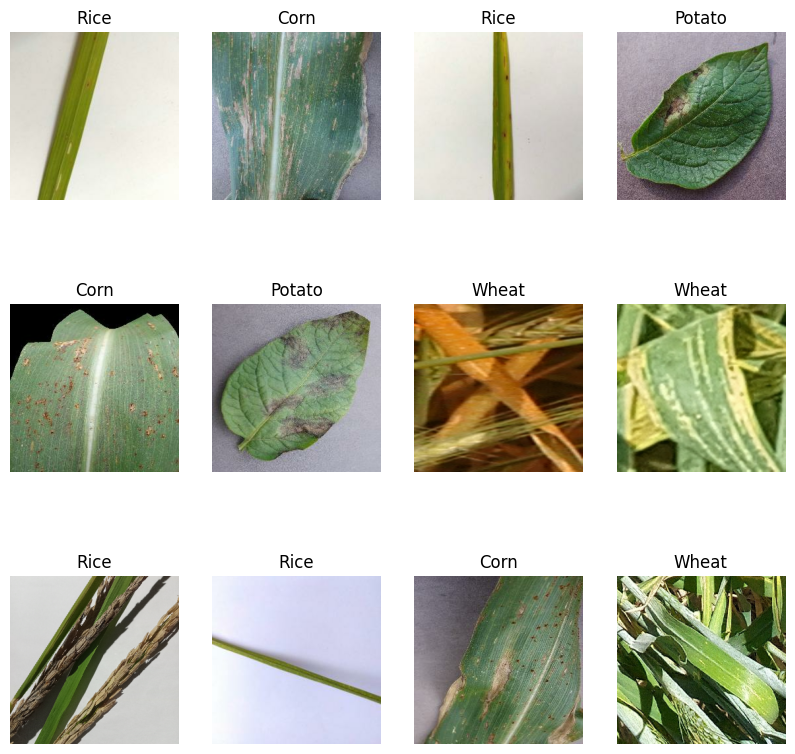

In [9]:
plt.figure(figsize=(10,10))
from numpy import uint16
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

**TRAIN TEST SPLIT**

80 % TRAINING

20 % VALIDATION (10% validation + 10% Test)

#### Function to Divide Dataset into train , validation and test

In [10]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        daaset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [12]:
len(train_dataset)

333

In [13]:
len(val_dataset)

41

In [14]:
len(test_dataset)

43

### Cache, Shuffle, and Prefetch Dataset

In [15]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# BUILDING MODEL

### RESIZE & RESCALE

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### DATA AUGMENTATION

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## MODEL ARCHITECTURE

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 17

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### Model Complilation

#### We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
333/333 [==============================] - 211s 634ms/step - loss: 0.5507 - accuracy: 0.7938 - val_loss: 0.2820 - val_accuracy: 0.9108
Epoch 2/10
333/333 [==============================] - 188s 565ms/step - loss: 0.2274 - accuracy: 0.9276 - val_loss: 0.1671 - val_accuracy: 0.9466
Epoch 3/10
333/333 [==============================] - 189s 569ms/step - loss: 0.1557 - accuracy: 0.9488 - val_loss: 0.2299 - val_accuracy: 0.9268
Epoch 4/10
333/333 [==============================] - 188s 566ms/step - loss: 0.1599 - accuracy: 0.9491 - val_loss: 0.1033 - val_accuracy: 0.9634
Epoch 5/10
333/333 [==============================] - 189s 568ms/step - loss: 0.1184 - accuracy: 0.9611 - val_loss: 0.1107 - val_accuracy: 0.9672
Epoch 6/10
333/333 [==============================] - 189s 569ms/step - loss: 0.0953 - accuracy: 0.9697 - val_loss: 0.1142 - val_accuracy: 0.9657
Epoch 7/10
333/333 [==============================] - 189s 568ms/step - loss: 0.0926 - accuracy: 0.9699 - val_loss: 0.0973 -

In [22]:
result = model.evaluate(test_dataset)

43/43 [==============================] - 28s 110ms/step - loss: 0.0697 - accuracy: 0.9779


In [23]:
result

[0.06967108696699142, 0.9778761267662048]

In [24]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 333}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

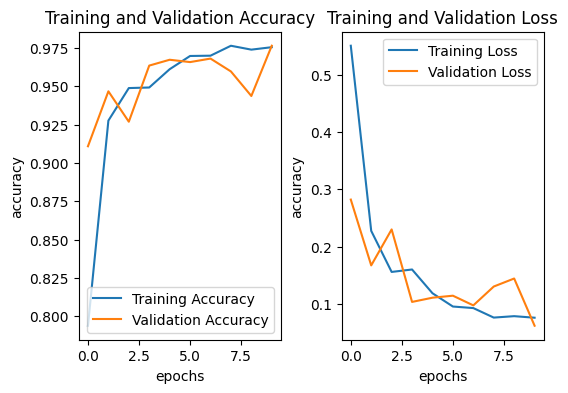

In [27]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Loss')
plt.subplots_adjust(wspace=0.3)
plt.show()

## Running Prediction on sample images

In [28]:
import numpy as np
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


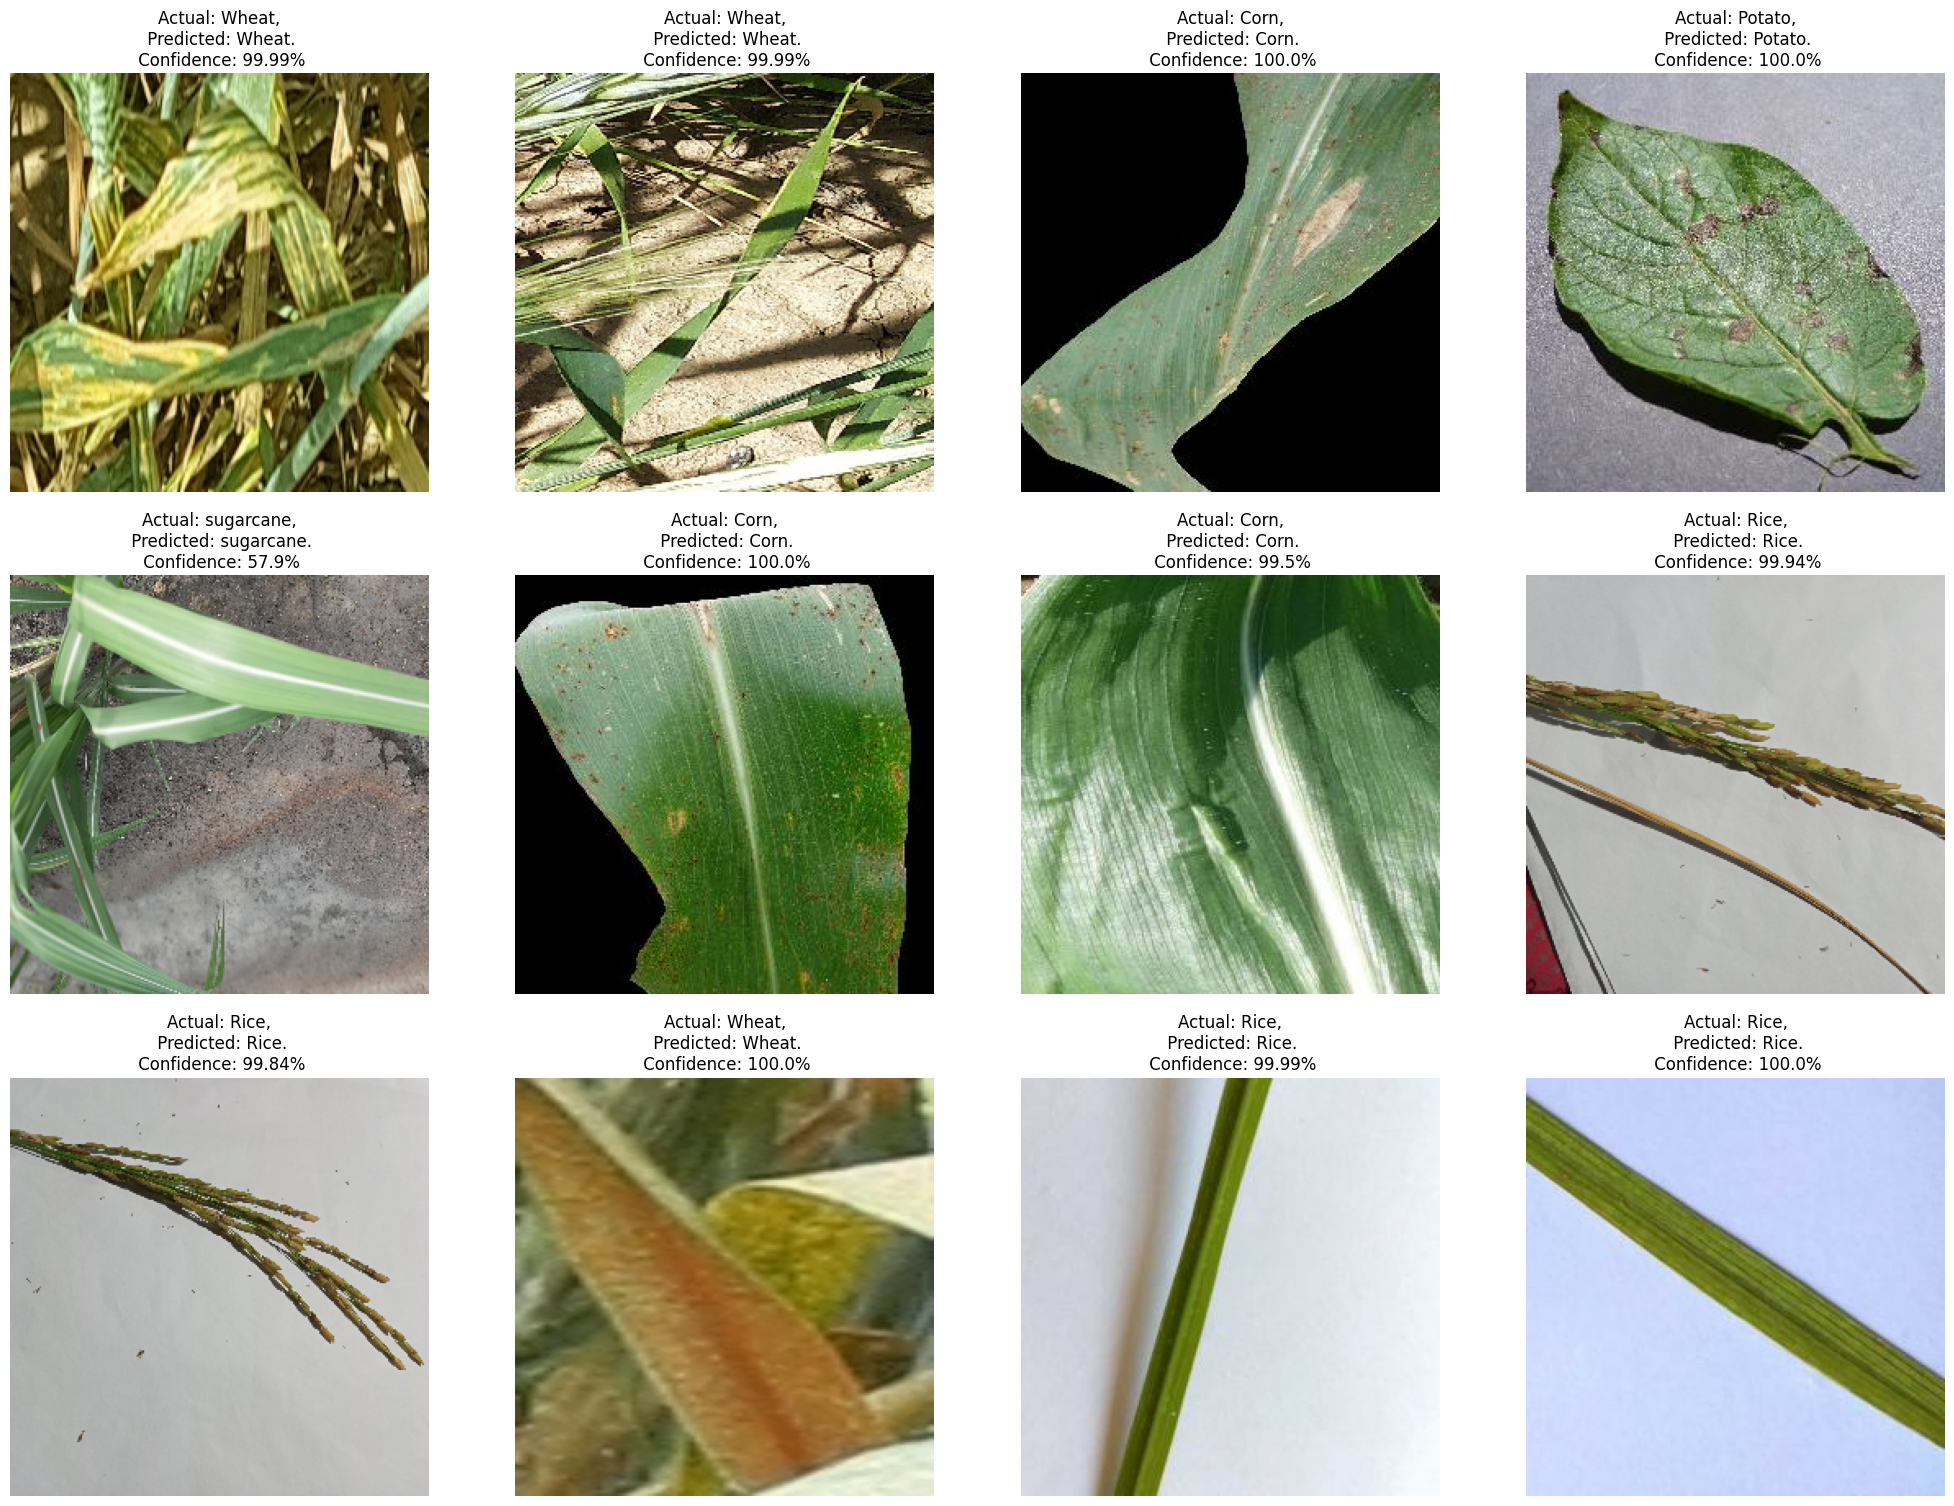

In [29]:
plt.figure(figsize=(25, 25))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")